In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



In [3]:
import librosa
from librosa import display
import pandas as pd
import numpy as np
import os
from datetime import datetime

In [4]:
from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
#from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Input 
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l1
from keras.utils.vis_utils import plot_model
from datetime import datetime
from sklearn import metrics

In [5]:
work_dir = '/kaggle/' 
audio_path = "../input/covid19-cough-audio-classification"
#audio_indir = data_dir+"Respiratory_Sound_Database\\audio_and_txt_files\\"
audio_outdir = work_dir + "working/"
#text_outdir = data_dir + "annotations\\"

metadata_file = "metadata_compiled.csv"
metadata=pd.read_csv('../input/covid19-cough-audio-classification/metadata_compiled.csv')

In [6]:
print(metadata['status'].isnull().value_counts())
print(metadata['age'].isnull().value_counts())
print(metadata['respiratory_condition'].isnull().value_counts())
print(metadata['fever_muscle_pain'].isnull().value_counts())
print(metadata['gender'].isnull().value_counts())

False    16224
True     11326
Name: status, dtype: int64
False    15218
True     12332
Name: age, dtype: int64
False    16224
True     11326
Name: respiratory_condition, dtype: int64
False    16224
True     11326
Name: fever_muscle_pain, dtype: int64
False    16224
True     11326
Name: gender, dtype: int64


In [7]:
# remove entries where either status or age is NA
print("metadata entries before cleaning NAs: {}".format(metadata.shape[0]))
metadata = metadata.loc[~((metadata['status'].isnull() ) | (metadata['age'].isnull()) | (metadata['respiratory_condition'].isnull()) | (metadata['fever_muscle_pain'].isnull()) |(metadata['gender'].isnull())  )]
print("metadata entries after cleaning NAs: {}".format(metadata.shape[0]))

metadata entries before cleaning NAs: 27550
metadata entries after cleaning NAs: 15218


In [7]:
print(metadata['status'].isnull().value_counts())
print(metadata['age'].isnull().value_counts())
print(metadata['respiratory_condition'].isnull().value_counts())
print(metadata['fever_muscle_pain'].isnull().value_counts())
print(metadata['gender'].isnull().value_counts())

False    15218
Name: status, dtype: int64
False    15218
Name: age, dtype: int64
False    15218
Name: respiratory_condition, dtype: int64
False    15218
Name: fever_muscle_pain, dtype: int64
False    15218
Name: gender, dtype: int64


In [8]:
metadata['fever_muscle_pain']=metadata['fever_muscle_pain'].apply(lambda x: 0 if x==False else 1)
metadata['gender']=metadata['gender'].apply(lambda x: 0 if x=="female" else 1)
metadata['respiratory_condition']=metadata['respiratory_condition'].apply(lambda x: 0 if x==False else 1)
metadata

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,2020-04-13T22:23:06.997578+00:00,0.9968,13.146502,NaN,NaN,21.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,2020-10-18T15:11:02.106636+00:00,0.7811,12.566406,45.7,4.9,20.0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27541,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,2020-04-22T05:40:51.730942+00:00,0.5591,11.209351,13.0,77.6,26.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,2020-06-05T03:41:37.481463+00:00,1.0000,33.661082,-34.5,-58.5,23.0,1,0,0,...,good,dry,False,False,False,False,False,True,healthy_cough,pseudocough
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,2020-05-02T10:18:27.348859+00:00,0.9784,9.635425,14.3,121.1,22.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27544,fff13fa2-a725-49ef-812a-39c6cedda33d,2020-04-13T17:51:36.956822+00:00,0.7154,14.162062,31.9,34.7,21.0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
metadata['status'].value_counts()

healthy        11732
symptomatic     2521
COVID-19         965
Name: status, dtype: int64

In [10]:
metadata2=metadata[['uuid','age','respiratory_condition','fever_muscle_pain','gender','status']]
metadata2

,uuid,age,respiratory_condition,fever_muscle_pain,gender,status
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,15.0,0,0,1,healthy
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,46.0,0,0,0,healthy
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,34.0,1,0,1,healthy
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,21.0,0,0,1,healthy
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,20.0,1,0,1,healthy
...,...,...,...,...,...,...
27541,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,26.0,0,0,1,healthy
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,23.0,0,0,1,healthy
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,22.0,0,0,0,healthy
27544,fff13fa2-a725-49ef-812a-39c6cedda33d,21.0,1,0,1,healthy


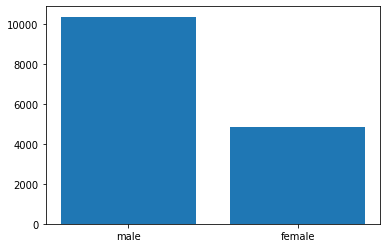

In [11]:
import matplotlib.pyplot as plt
gen=["male","female"]
count=[metadata2['gender'].value_counts()[1],metadata2['gender'].value_counts()[0]]
plt.bar(gen,count)
plt.show()

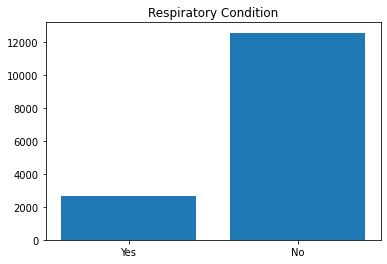

In [12]:
gen=["Yes","No"]
count=[metadata2['respiratory_condition'].value_counts()[1],metadata2['respiratory_condition'].value_counts()[0]]
plt.title("Respiratory Condition")
plt.bar(gen,count)
plt.show()

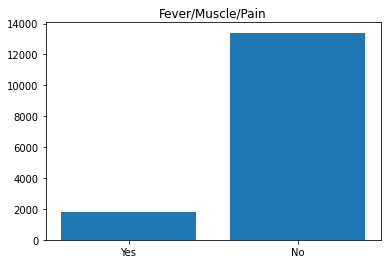

In [13]:
gen=["Yes","No"]
count=[metadata2['fever_muscle_pain'].value_counts()[1],metadata2['fever_muscle_pain'].value_counts()[0]]
plt.title("Fever/Muscle/Pain")
plt.bar(gen,count)
plt.show()

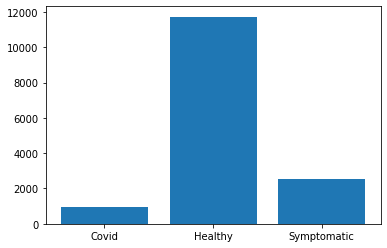

In [14]:
gen=["Covid","Healthy","Symptomatic"]
count=[metadata2['status'].value_counts()['COVID-19'],metadata2['status'].value_counts()['healthy'],metadata2['status'].value_counts()['symptomatic']]
plt.bar(gen,count)
plt.show()

gender
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

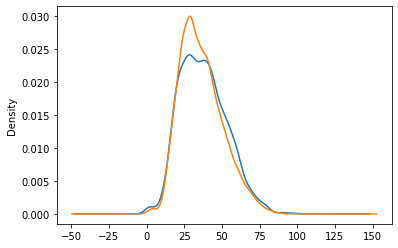

In [15]:
metadata2.groupby('gender').age.plot(kind='kde')

<AxesSubplot:ylabel='Frequency'>

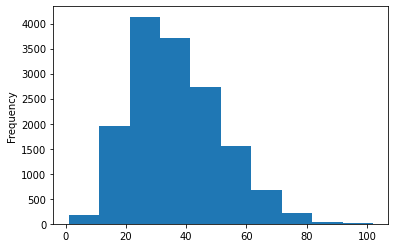

In [16]:
metadata2.age.plot(kind='hist')

In [17]:
symp_df=metadata[metadata.status=='symptomatic']
symp_df=symp_df.head(1200)
symp_df

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
12,0029d048-898a-4c70-89c7-0815cdcf7391,2020-07-16T03:01:55.059762+00:00,1.0000,9.624196,NaN,NaN,35.0,1,1,0,...,good,dry,False,False,False,False,False,True,upper_infection,mild
25,00432f00-2477-4faf-a440-cc1276065b4a,2020-04-30T11:01:13.536686+00:00,0.6911,15.926406,48.9,2.6,31.0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,006d8d1c-2bf6-46a6-8ef2-1823898a4733,2020-04-22T10:24:21.408615+00:00,1.0000,13.284361,NaN,NaN,28.0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,006daa68-31b7-44ab-b0c6-7e5ef4e1ebf7,2020-10-14T08:47:01.990751+00:00,0.9961,32.564843,NaN,NaN,33.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,008c1c9e-aeef-40c5-846c-24f1b964f884,2020-04-12T21:25:00.131353+00:00,1.0000,55.824914,48.9,2.7,44.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13193,7a568e63-08a1-4be9-a33a-ad8348c22617,2020-09-24T18:56:23.624645+00:00,0.8961,18.534933,NaN,NaN,39.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13203,7a6db0d1-ba36-4823-add6-47f7304d83d5,2020-08-21T12:44:11.606094+00:00,0.9669,10.108650,NaN,NaN,26.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13228,7a97059d-41ad-4411-82a9-f38c91197320,2020-05-30T23:36:46.184121+00:00,0.7027,11.703798,NaN,NaN,21.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13232,7aa19749-6bb8-40e1-a4ee-823290466b0f,2020-04-13T09:25:42.310644+00:00,0.9963,18.459386,39.6,-0.3,73.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
covid_df=metadata[metadata.status=='COVID-19']
covid_df

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
133,01424527-9c3b-4b6e-96f1-9eea3150819b,2020-10-18T15:51:28.858079+00:00,0.0000,16.047069,48.9,2.5,39.0,0,0,0,...,no_cough,NaN,False,False,False,False,False,False,NaN,NaN
140,015576c8-2b03-4dcb-b251-78a984fe86fe,2020-06-22T00:21:42.091345+00:00,1.0000,12.265701,NaN,NaN,27.0,1,0,0,...,good,unknown,False,False,False,False,False,True,obstructive_disease,mild
144,015ec831-e765-44ee-aefc-10dfd95dec78,2020-04-14T03:28:58.264739+00:00,0.0000,16.549264,41.6,2.0,34.0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,01672ac0-dfd5-4aaf-b57b-d6dfa411b43d,2020-04-14T10:06:12.730478+00:00,0.0931,0.000000,NaN,NaN,1.0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,0177b817-0ba3-498a-bc05-48bc66cc91b8,2020-04-14T10:55:38.245408+00:00,1.0000,20.441756,NaN,NaN,18.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27300,fd8d6e46-75de-42b3-a7ef-30d5294b915d,2020-05-05T17:57:01.830977+00:00,1.0000,13.224609,NaN,NaN,19.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27315,fdbabb79-c296-4b93-9e02-06b290916fe7,2020-04-10T14:52:39.570226+00:00,1.0000,11.986657,-12.1,-77.0,42.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27417,feb52c0e-de52-4706-aded-d9dcefcea62d,2020-04-10T21:18:32.936362+00:00,0.3081,0.000000,NaN,NaN,51.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27519,ffa8bc1f-7ef8-48ef-a951-78a4f2897c0c,2020-11-10T13:38:45.060541+00:00,0.0118,0.000000,47.4,8.5,37.0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
healthy_df=metadata[metadata.status=='healthy']
healthy_df=healthy_df.head(1200)
healthy_df

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,2020-04-13T22:23:06.997578+00:00,0.9968,13.146502,NaN,NaN,21.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,2020-10-18T15:11:02.106636+00:00,0.7811,12.566406,45.7,4.9,20.0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,1944e249-b0c8-4e10-ad8c-195d2ad4833c,2020-04-16T11:33:43.261566+00:00,0.7941,0.000000,NaN,NaN,26.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2712,194584e5-fa76-4a88-a7ab-073095aab3cc,2020-11-13T10:33:41.172373+00:00,0.9964,22.819712,46.9,8.4,42.0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2714,1948ec03-fa5c-4301-a88b-29400c67903f,2020-04-21T15:10:00.617360+00:00,0.2925,15.748968,NaN,NaN,32.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2716,194bcca1-e83c-4d5a-b49f-9841f967712f,2020-04-17T03:04:43.137202+00:00,0.9941,14.398196,31.8,-93.2,31.0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
def feature_extract(file):
    audio,sr=librosa.load(file_name,res_type='kaiser_fast')
    mfccs_feature=librosa.feature.mfcc(y=audio,sr=sr,n_mfcc=40)
    mfccs_scaled_feature=np.mean(mfccs_feature.T,axis=0)
    return mfccs_scaled_feature

In [21]:
import warnings
warnings.filterwarnings('ignore', '.*PySoundFile failed. Trying audioread instead*.', )
extracted_feature=[]
for idx,row in metadata.iterrows():
    file_name='../input/covid19-cough-audio-classification/'+row["uuid"]+".webm"
    tmp_audiofilename = row["uuid"]+".webm"
    if not os.path.exists(file_name):
        # try to look for a .ogg file
        tmp_audiofilename = row["uuid"]+".ogg"
        file_name='../input/covid19-cough-audio-classification/'+row["uuid"]+".ogg"
        if not os.path.exists(file_name):
                warnings.warn("WARNING! Could not find audio file for UUID: {}  . Skipping.".format(row["uuid"]))
                continue
        if idx%2==0:
            print(idx,"+ files Read.....")
    data=feature_extract(file_name)
    extracted_feature.append([row["uuid"],data])

70 + files Read.....
248 + files Read.....
260 + files Read.....
358 + files Read.....
430 + files Read.....
502 + files Read.....
550 + files Read.....
564 + files Read.....
574 + files Read.....
646 + files Read.....
678 + files Read.....
690 + files Read.....
718 + files Read.....
732 + files Read.....
752 + files Read.....
942 + files Read.....
1042 + files Read.....
1162 + files Read.....
1170 + files Read.....
1276 + files Read.....
1390 + files Read.....
1448 + files Read.....
1572 + files Read.....
1642 + files Read.....
1670 + files Read.....
1674 + files Read.....
1796 + files Read.....
1936 + files Read.....
1956 + files Read.....
2038 + files Read.....
2080 + files Read.....
2138 + files Read.....
2190 + files Read.....
2244 + files Read.....
2384 + files Read.....
2474 + files Read.....
2590 + files Read.....
2598 + files Read.....
2638 + files Read.....
2646 + files Read.....
2666 + files Read.....
2684 + files Read.....
2700 + files Read.....
2726 + files Read.....
2788 

In [22]:
extracted_feature_df=pd.DataFrame(extracted_feature,columns=["uuid","mfcc"])
extracted_feature_df

,uuid,mfcc
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,"[-563.2874, 18.23792, -2.3400497, 5.7208853, -..."
1,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,"[-736.351, 55.817093, 9.0540085, 1.9002738, -1..."
2,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,"[-279.64, 102.03124, -26.996693, 16.89043, -22..."
3,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,"[-519.8216, 26.094429, -28.72866, 8.002989, -1..."
4,001e2f19-d81c-4029-b33c-d2db56b23a4a,"[-524.22455, 17.533, -1.9887367, 6.6113377, -0..."
...,...,...
15213,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,"[-277.3534, 96.50647, -2.5476043, -13.43712, -..."
15214,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,"[-420.7814, 24.159294, -7.4626074, -1.1088455,..."
15215,ffeea120-92a4-40f9-b692-c3865c7a983f,"[-509.06058, 29.669348, -13.902602, 3.8848453,..."
15216,fff13fa2-a725-49ef-812a-39c6cedda33d,"[-542.4676, 25.574665, -14.510176, 1.2691067, ..."


In [23]:
extracted_feature_df.to_csv('mfcc.csv',index=False)

In [24]:
all_data = metadata2.merge(extracted_feature_df,how='inner',on="uuid")
all_data

,uuid,age,respiratory_condition,fever_muscle_pain,gender,status,mfcc
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,15.0,0,0,1,healthy,"[-563.2874, 18.23792, -2.3400497, 5.7208853, -..."
1,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,46.0,0,0,0,healthy,"[-736.351, 55.817093, 9.0540085, 1.9002738, -1..."
2,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,34.0,1,0,1,healthy,"[-279.64, 102.03124, -26.996693, 16.89043, -22..."
3,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,21.0,0,0,1,healthy,"[-519.8216, 26.094429, -28.72866, 8.002989, -1..."
4,001e2f19-d81c-4029-b33c-d2db56b23a4a,20.0,1,0,1,healthy,"[-524.22455, 17.533, -1.9887367, 6.6113377, -0..."
...,...,...,...,...,...,...,...
15213,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,26.0,0,0,1,healthy,"[-277.3534, 96.50647, -2.5476043, -13.43712, -..."
15214,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,23.0,0,0,1,healthy,"[-420.7814, 24.159294, -7.4626074, -1.1088455,..."
15215,ffeea120-92a4-40f9-b692-c3865c7a983f,22.0,0,0,0,healthy,"[-509.06058, 29.669348, -13.902602, 3.8848453,..."
15216,fff13fa2-a725-49ef-812a-39c6cedda33d,21.0,1,0,1,healthy,"[-542.4676, 25.574665, -14.510176, 1.2691067, ..."


In [25]:
all_data = metadata2.merge(extracted_feature_df,how='inner',on="uuid")
all_data

,uuid,age,respiratory_condition,fever_muscle_pain,gender,status,mfcc
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,15.0,0,0,1,healthy,"[-563.2874, 18.23792, -2.3400497, 5.7208853, -..."
1,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,46.0,0,0,0,healthy,"[-736.351, 55.817093, 9.0540085, 1.9002738, -1..."
2,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,34.0,1,0,1,healthy,"[-279.64, 102.03124, -26.996693, 16.89043, -22..."
3,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,21.0,0,0,1,healthy,"[-519.8216, 26.094429, -28.72866, 8.002989, -1..."
4,001e2f19-d81c-4029-b33c-d2db56b23a4a,20.0,1,0,1,healthy,"[-524.22455, 17.533, -1.9887367, 6.6113377, -0..."
...,...,...,...,...,...,...,...
15213,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,26.0,0,0,1,healthy,"[-277.3534, 96.50647, -2.5476043, -13.43712, -..."
15214,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,23.0,0,0,1,healthy,"[-420.7814, 24.159294, -7.4626074, -1.1088455,..."
15215,ffeea120-92a4-40f9-b692-c3865c7a983f,22.0,0,0,0,healthy,"[-509.06058, 29.669348, -13.902602, 3.8848453,..."
15216,fff13fa2-a725-49ef-812a-39c6cedda33d,21.0,1,0,1,healthy,"[-542.4676, 25.574665, -14.510176, 1.2691067, ..."


In [26]:
x=np.array(all_data[['age','gender','respiratory_condition','fever_muscle_pain']])
a=np.array(all_data['mfcc'].tolist())
y=np.array(all_data['status'].tolist())
x_concat=np.concatenate((a, x), axis=1)

In [27]:
x_concat

array([[-563.28741455,   18.23792076,   -2.34004974, ...,    1.        ,
           0.        ,    0.        ],
       [-736.35101318,   55.8170929 ,    9.05400848, ...,    0.        ,
           0.        ,    0.        ],
       [-279.64001465,  102.03124237,  -26.99669266, ...,    1.        ,
           1.        ,    0.        ],
       ...,
       [-509.06057739,   29.66934776,  -13.9026022 , ...,    0.        ,
           0.        ,    0.        ],
       [-542.46759033,   25.57466507,  -14.5101757 , ...,    1.        ,
           1.        ,    0.        ],
       [-265.3416748 ,  131.14451599,  -43.63661194, ...,    1.        ,
           1.        ,    1.        ]])

In [28]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [29]:
y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [30]:
y.shape

(15218, 3)

In [31]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x_concat,y,test_size=0.2,random_state=0)

In [32]:
X_train=np.array(X_train)
num_labels=y.shape[1]

In [33]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(x_concat.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4500      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [34]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [35]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
381/381 [==============================] - 4s 4ms/step - loss: 7.9119 - accuracy: 0.6139 - val_loss: 0.8714 - val_accuracy: 0.7809

Epoch 00001: val_loss improved from inf to 0.87144, saving model to saved_models/audio_classification.hdf5
Epoch 2/100
381/381 [==============================] - 1s 3ms/step - loss: 0.9413 - accuracy: 0.7332 - val_loss: 0.7581 - val_accuracy: 0.7809

Epoch 00002: val_loss improved from 0.87144 to 0.75815, saving model to saved_models/audio_classification.hdf5
Epoch 3/100
381/381 [==============================] - 1s 3ms/step - loss: 0.7718 - accuracy: 0.7584 - val_loss: 0.7093 - val_accuracy: 0.7809

Epoch 00003: val_loss improved from 0.75815 to 0.70934, saving model to saved_models/audio_classification.hdf5
Epoch 4/100
381/381 [==============================] - 1s 3ms/step - loss: 0.7241 - accuracy: 0.7657 - val_loss: 0.6750 - val_accuracy: 0.7809

Epoch 00004: val_loss improved from 0.70934 to 0.67503, saving model to saved_models/audio_clas

In [36]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7808803915977478


In [39]:
input=X_test[2]
input_array=np.asarray(input)
input_reshaped=input_array.reshape(1,-1)
input_reshaped.shape
model.predict(input_reshaped)

array([[0.06421201, 0.7683075 , 0.16748048]], dtype=float32)

In [40]:
model.save('my_model.h5')

In [8]:
# load the saved model
loaded_model = tf.keras.models.load_model('my_model.h5')

OSError: SavedModel file does not exist at: my_model.h5/{saved_model.pbtxt|saved_model.pb}

In [9]:
def feature_extract(file):
    audio,sr=librosa.load(file_name,res_type='kaiser_fast')
    mfccs_feature=librosa.feature.mfcc(y=audio,sr=sr,n_mfcc=40)
    mfccs_scaled_feature=np.mean(mfccs_feature.T,axis=0)
    return mfccs_scaled_feature

In [ ]:
def ANN_predict(file_name,predict_demo_fac):
    predict_data=feature_extract(file_name)
    #'age','gender','respiratory_condition','fever_muscle_pain' order
    predict_concat=np.concatenate((predict_data, predict_demo_fac), axis=0)
    input=predict_concat
    input_array=np.asarray(input)
    input_reshaped=input_array.reshape(1,-1)
    input_reshaped.shape
    print("  Covid-19   Healthy   Symptomatic")
    print(loaded_model.predict(input_reshaped))




filename='../input/pred-audio/Recording.m4a'
predict_demo_fac=[19,1,0,0]
ANN_predict(filename,predict_demo_fac)